<a href="https://colab.research.google.com/github/GoZaZombie/CTIP-Assignment-2/blob/main/GRUTrainSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib



#import datasets

EmailSpamData = pd.read_csv(r'../DataSets/emails.csv', encoding='latin-1')
SMSSpamData = pd.read_csv(r'../DataSets/spam.csv', encoding='latin-1')


#Normalizing the column name scheme
SMSSpamData = SMSSpamData.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
SMSSpamData = SMSSpamData.rename(columns={'v1': 'Classification', 'v2': 'Message'})
EmailSpamData = EmailSpamData.rename(columns={'text': 'Message','spam': 'Classification'})

#reorder Columns
EmailSpamData = EmailSpamData[['Message', 'Classification']]
SMSSpamData = SMSSpamData[['Message', 'Classification']]


#normalize values for spam and "ham"
SMSSpamData.loc[SMSSpamData['Classification'] == 'spam', 'Classification'] = 1
SMSSpamData.loc[SMSSpamData['Classification'] == 'ham', 'Classification'] = 0





#debugging
##print(SpamData1.tail(20))
#print(SpamData2.tail(20))

#join the data sets
#SpamData = pd.concat([SpamData1, SpamData2], ignore_index=True)

#debugging
#print(SpamData.tail(20))


tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>") #handles words that were unseen during training and stops it from crashing
tokenizer.fit_on_texts(EmailSpamData['Message']) #targets messages since thats where the unseen words will appear (alot have random jumbles of letters/symbols)

sequences = tokenizer.texts_to_sequences(EmailSpamData['Message'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding= 'post') #padds the the sequences to make them the same length by using 0's has placeholders




GRUModel = Sequential([  #defines the details of the model
    Embedding(input_dim=5000, output_dim=128),  #note input_dim isn't here since it throws and error, newer keras seem to automatically detect input length
    GRU(32),
    Dense(1, activation='sigmoid')
])
X = padded_sequences
Y = EmailSpamData['Classification'] #seperates the data into x and y. x being the messages and y being the classification.
X_TrainData, X_TestData, Y_TrainData, Y_TestData = train_test_split(X, Y , test_size=0.2, random_state =42) #splits the data into training and testing sets, currently 80 - 20 split

Y_TestData = np.array(Y_TestData, dtype=int)
Y_TrainData= np.array(Y_TrainData,  dtype=int) #issues with the model training, needed to covert it to integers and np.arrays

X_TrainData = np.array(X_TrainData)
X_TestData = np.array(X_TestData)



GRUModel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
FirstIteration = GRUModel.fit(
    X_TrainData,
    Y_TrainData,
    epochs=5,
    batch_size=32,
    validation_data=(X_TestData, Y_TestData),
    verbose=1
)


#debugging
#print(TrainData.tail(20))
#print(TestData.tail(20))

Epoch 1/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.7997 - loss: 0.4174 - val_accuracy: 0.9023 - val_loss: 0.2080
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8507 - loss: 0.3195 - val_accuracy: 0.9363 - val_loss: 0.1757
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9681 - loss: 0.1110 - val_accuracy: 0.9625 - val_loss: 0.1028
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9854 - loss: 0.0596 - val_accuracy: 0.9651 - val_loss: 0.1173
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9915 - loss: 0.0388 - val_accuracy: 0.9695 - val_loss: 0.1061


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9695 - loss: 0.1061
Test Loss: 0.10608801990747452
Test Accuracy: 0.9694589972496033


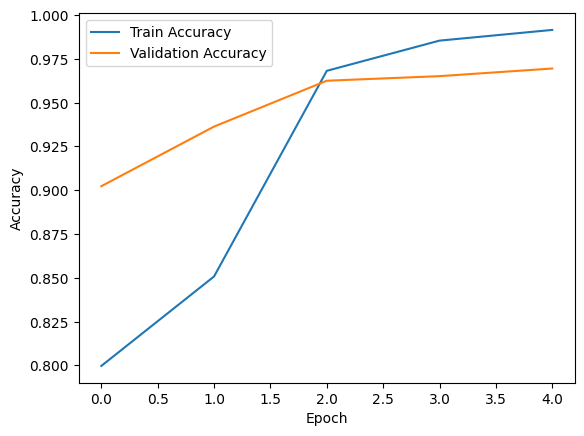

In [5]:
loss, accuracy = GRUModel.evaluate(X_TestData, Y_TestData)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

plt.plot(FirstIteration.history['accuracy'], label='Train Accuracy')
plt.plot(FirstIteration.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


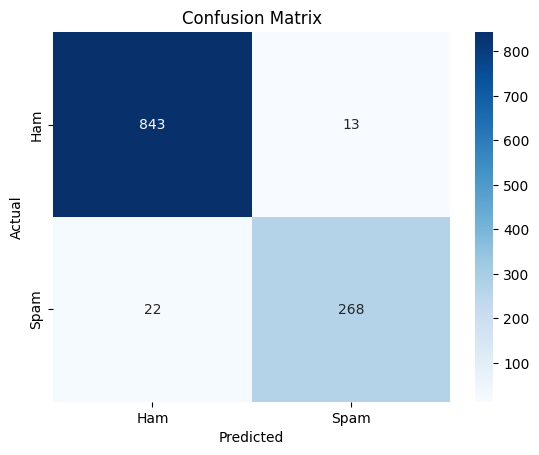

Classification
0    4360
1    1368
Name: count, dtype: int64


In [6]:
Y_PredData = GRUModel.predict(X_TestData)

# Convert probabilities to binary predictions
Y_PredBinary = (Y_PredData > 0.5).astype(int).flatten()

cm = confusion_matrix(Y_TestData, Y_PredBinary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(EmailSpamData['Classification'].value_counts())


In [7]:
GRUModel.save('GRUModelEmail.h5')
joblib.dump(tokenizer, 'tokenizer.pkl')

['tokenizer.pkl']

In [8]:
print("\nClassification Report:")
print(classification_report(Y_TestData, Y_PredBinary))


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       856
           1       0.95      0.92      0.94       290

    accuracy                           0.97      1146
   macro avg       0.96      0.95      0.96      1146
weighted avg       0.97      0.97      0.97      1146

